
Training Model: MLP + Linear

Epoch 1: Train Loss=0.5555, Test Acc=0.8109
Epoch 2: Train Loss=0.4644, Test Acc=0.8455
Epoch 3: Train Loss=0.4534, Test Acc=0.8435

Training Model: CNN + Linear

Epoch 1: Train Loss=0.4722, Test Acc=0.8739
Epoch 2: Train Loss=0.3342, Test Acc=0.8932
Epoch 3: Train Loss=0.2962, Test Acc=0.8976

Training Model: MLP + Sigmoid

Epoch 1: Train Loss=0.6857, Test Acc=0.8389
Epoch 2: Train Loss=0.4055, Test Acc=0.8641
Epoch 3: Train Loss=0.3640, Test Acc=0.8705

Training Model: CNN + Sigmoid

Epoch 1: Train Loss=0.9697, Test Acc=0.7966
Epoch 2: Train Loss=0.4906, Test Acc=0.8334
Epoch 3: Train Loss=0.4177, Test Acc=0.8612

Training Model: MLP + ReLU

Epoch 1: Train Loss=0.5296, Test Acc=0.8531
Epoch 2: Train Loss=0.3753, Test Acc=0.8745
Epoch 3: Train Loss=0.3361, Test Acc=0.8764

Training Model: CNN + ReLU

Epoch 1: Train Loss=0.5143, Test Acc=0.8622
Epoch 2: Train Loss=0.3345, Test Acc=0.8862
Epoch 3: Train Loss=0.2843, Test Acc=0.8996

Training Model: MLP + L

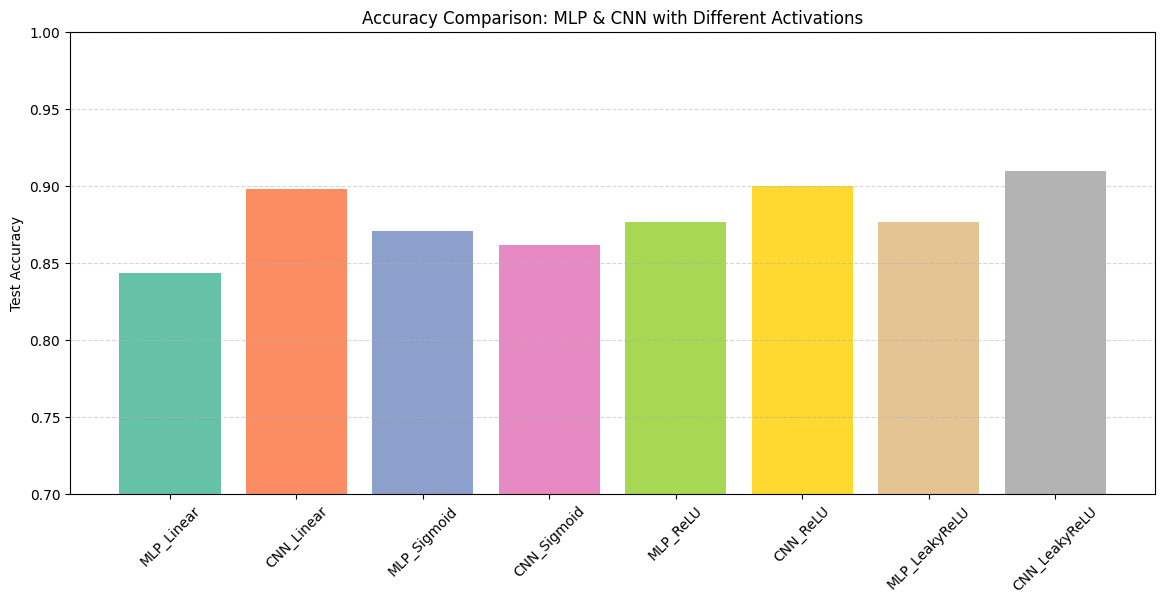

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
import numpy as np


# 1. Load dataset & basic preprocessing
TRAIN_CSV_PATH = "/content/fashion-mnist_train.csv"
TEST_CSV_PATH  = "/content/fashion-mnist_test.csv"

train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df  = pd.read_csv(TEST_CSV_PATH)

def preprocess_fashion_df(df):
    y = df.iloc[:, 0].values
    X = df.iloc[:, 1:].values / 255.0
    X = X.reshape(-1, 1, 28, 28)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    return X, y

X_train, y_train = preprocess_fashion_df(train_df)
X_test,  y_test  = preprocess_fashion_df(test_df)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=1000, shuffle=False)


# 2. Activation Function Dictionary

activation_functions = {
    "Linear": nn.Identity(),
    "Sigmoid": nn.Sigmoid(),
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU()
}


# 3. MLP Model (Fully Connected Network)

class MLP(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256), activation_fn,
            nn.Linear(256, 128), activation_fn,
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)


# 4. CNN Model (Convolution + Pooling)

class CNN(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            activation_fn,
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            activation_fn,
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32*7*7, 128),
            activation_fn,
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# 5. Training Function (Train One Epoch)

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


# 6. Testing Function (Accuracy Evaluation)

def test(model, device, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    return test_loss / len(test_loader), correct / total

# 7. Robustness Test (Noise & Occlusion)

def robustness_test(model, device, test_loader, noise_std=0.2, occlusion_ratio=0.2):
    model.eval()
    correct_noise = 0
    correct_occlusion = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            total += target.size(0)

            # Gaussian noise test
            noisy = torch.clamp(data + torch.randn_like(data) * noise_std, 0, 1)
            pred_noise = model(noisy).argmax(dim=1)
            correct_noise += (pred_noise == target).sum().item()

            # Random pixel occlusion test
            occluded = data.clone()
            n_pixels = int(occlusion_ratio * 28 * 28)
            for i in range(occluded.size(0)):
                idx = torch.randperm(28*28)[:n_pixels]
                occluded[i].view(-1)[idx] = 0
            pred_occ = model(occluded).argmax(dim=1)
            correct_occlusion += (pred_occ == target).sum().item()

    return correct_noise / total, correct_occlusion / total


# 8. Main Experiment Loop
# Train all model–activation combinations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

model_structures = {"MLP": MLP, "CNN": CNN}

for act_name, act_fn in activation_functions.items():
    for model_name, model_class in model_structures.items():

        print(f"\n==============================")
        print(f"Training Model: {model_name} + {act_name}")
        print(f"==============================\n")

        model = model_class(act_fn).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        start_time = time.time()
        for epoch in range(3):
            train_loss = train(model, device, train_loader, optimizer, criterion)
            test_loss, test_acc = test(model, device, test_loader, criterion)
            print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Test Acc={test_acc:.4f}")
        train_time = time.time() - start_time

        # Robustness evaluation
        acc_noise, acc_occlusion = robustness_test(model, device, test_loader)

        results.append({
            "Model": model_name,
            "Activation": act_name,
            "TestAcc": test_acc,
            "TrainTime(s)": round(train_time, 2),
            "NoiseAcc": round(acc_noise, 4),
            "OcclusionAcc": round(acc_occlusion, 4)
        })


# 9. Final Comparison Output

print("\n========== Final Comparison ==========\n")
print("{:<10} {:<12} {:<10} {:<12} {:<10} {:<12}".format(
    "Model","Activation","TestAcc","TrainTime(s)","NoiseAcc","OcclusionAcc"))

for r in results:
    print("{:<10} {:<12} {:<10.4f} {:<12} {:<10.4f} {:<12.4f}".format(
        r["Model"], r["Activation"], r["TestAcc"], r["TrainTime(s)"],
        r["NoiseAcc"], r["OcclusionAcc"]
    ))


# 10. Plot Accuracy Comparison

labels = [f"{r['Model']}_{r['Activation']}" for r in results]
acc_values = [r["TestAcc"] for r in results]

plt.figure(figsize=(14, 6))
colors = plt.cm.Set2(np.linspace(0, 1, len(labels)))
plt.bar(labels, acc_values, color=colors)
plt.ylabel("Test Accuracy")
plt.title("Accuracy Comparison: MLP & CNN with Different Activations")
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


Epoch 1: Train Loss=0.5259, Train Acc=0.8124, Test Loss=0.3907, Test Acc=0.8589
Epoch 2: Train Loss=0.3754, Train Acc=0.8630, Test Loss=0.3485, Test Acc=0.8727
Epoch 3: Train Loss=0.3367, Train Acc=0.8768, Test Loss=0.3497, Test Acc=0.8732
Epoch 4: Train Loss=0.3110, Train Acc=0.8869, Test Loss=0.3137, Test Acc=0.8858
Epoch 5: Train Loss=0.2930, Train Acc=0.8908, Test Loss=0.3174, Test Acc=0.8828


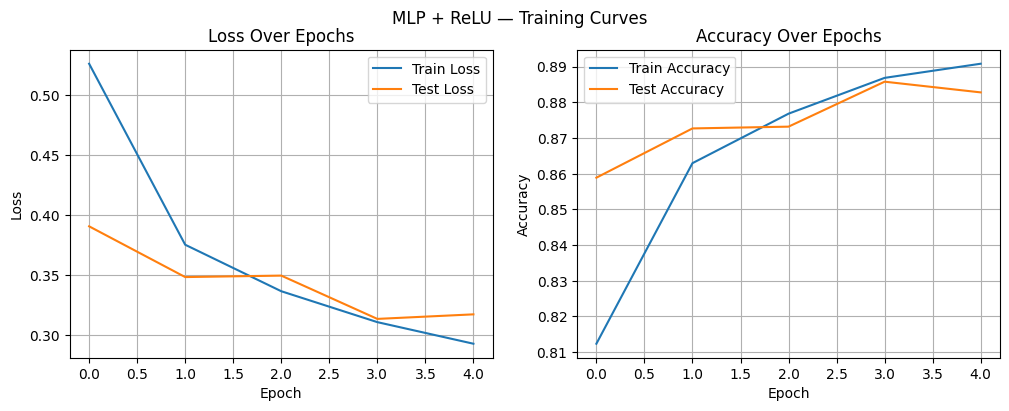

In [3]:

# Part 1 — Training History + Accuracy Tracking


def train_with_history(model, device, train_loader, test_loader, optimizer, criterion, epochs=5):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        # ---- Training ----
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # 计算 train accuracy
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # ---- Testing ----
        test_loss, test_acc = test(model, device, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, "
              f"Train Acc={train_accuracies[-1]:.4f}, "
              f"Test Loss={test_losses[-1]:.4f}, "
              f"Test Acc={test_accuracies[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies




# Part 2 — Plot Loss + Accuracy Curves


def plot_training_curves(train_losses, test_losses, train_accs, test_accs, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # -------- Loss Curve --------
    ax[0].plot(train_losses, label="Train Loss")
    ax[0].plot(test_losses, label="Test Loss")
    ax[0].set_title("Loss Over Epochs")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[0].grid(True)

    # -------- Accuracy Curve --------
    ax[1].plot(train_accs, label="Train Accuracy")
    ax[1].plot(test_accs, label="Test Accuracy")
    ax[1].set_title("Accuracy Over Epochs")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    ax[1].grid(True)

    plt.suptitle(title)
    plt.show()





model = MLP(nn.ReLU()).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, train_accs, test_accs = train_with_history(
    model, device, train_loader, test_loader, optimizer, criterion, epochs=5
)

plot_training_curves(train_losses, test_losses, train_accs, test_accs,
                     "MLP + ReLU — Training Curves")



Epoch 1: Train Loss=0.4910, Train Acc=0.8204, Test Loss=0.3422, Test Acc=0.8794
Epoch 2: Train Loss=0.3203, Train Acc=0.8845, Test Loss=0.3076, Test Acc=0.8886
Epoch 3: Train Loss=0.2760, Train Acc=0.8990, Test Loss=0.2558, Test Acc=0.9061
Epoch 4: Train Loss=0.2454, Train Acc=0.9103, Test Loss=0.2377, Test Acc=0.9125
Epoch 5: Train Loss=0.2216, Train Acc=0.9187, Test Loss=0.2307, Test Acc=0.9153
Final Test Accuracy: 0.9153


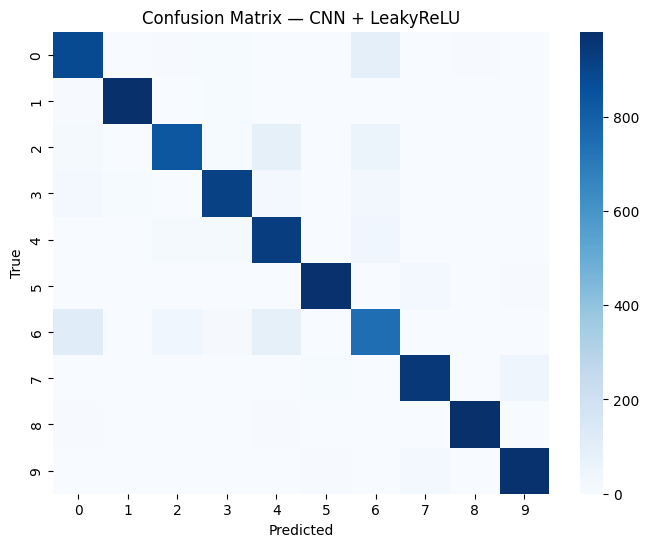

In [4]:
#
# Build Best Model: CNN + LeakyReLU
#

best_model = CNN(nn.LeakyReLU()).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train 5 Epochs (adjust if needed)
train_losses, test_losses, train_accs, test_accs = train_with_history(
    best_model, device, train_loader, test_loader, optimizer, criterion, epochs=5
)

print("Final Test Accuracy:", test_accs[-1])


#
# Confusion Matrix Plot
#

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, loader, device, title):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1).cpu().numpy()

            preds.extend(pred)
            trues.extend(target.numpy())

    cm = confusion_matrix(trues, preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        cmap="Blues",
        annot=False,
        xticklabels=[str(i) for i in range(10)],
        yticklabels=[str(i) for i in range(10)]
    )
    plt.title(f"Confusion Matrix — {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



plot_confusion_matrix(best_model, test_loader, device, "CNN + LeakyReLU")


Training CNN + LeakyReLU for generating the classification report...
Epoch 1: Train Loss=0.4924, Train Acc=0.8199, Test Loss=0.3263, Test Acc=0.8850
Epoch 2: Train Loss=0.3155, Train Acc=0.8851, Test Loss=0.3138, Test Acc=0.8786
Epoch 3: Train Loss=0.2722, Train Acc=0.9011, Test Loss=0.2642, Test Acc=0.9019

=== CNN + LeakyReLU Classification Report (Text) ===

              precision    recall  f1-score   support

           0      0.790     0.911     0.846      1000
           1      0.993     0.975     0.984      1000
           2      0.778     0.917     0.842      1000
           3      0.919     0.913     0.916      1000
           4      0.885     0.815     0.849      1000
           5      0.989     0.963     0.976      1000
           6      0.813     0.614     0.700      1000
           7      0.941     0.958     0.949      1000
           8      0.974     0.986     0.980      1000
           9      0.955     0.967     0.961      1000

    accuracy                          0.

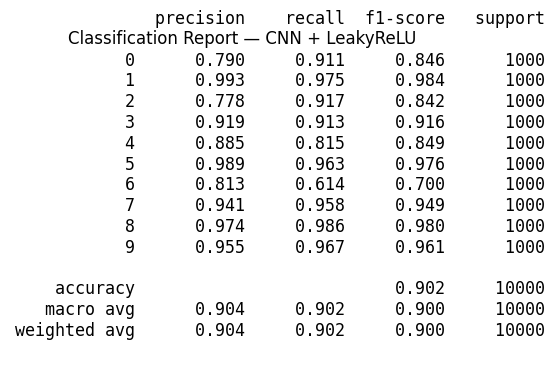

In [7]:
# Part 4 — Classification Report for CNN + LeakyReLU

from sklearn.metrics import classification_report

# --- Build CNN + LeakyReLU model ---
cnn_leakyrelu = CNN(nn.LeakyReLU()).to(device)

optimizer = optim.Adam(cnn_leakyrelu.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Training CNN + LeakyReLU for generating the classification report...")
train_with_history(cnn_leakyrelu, device, train_loader, test_loader, optimizer, criterion, epochs=3)

# --- Print classification report (text) ---
def print_class_report(model, loader, device):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            p = model(data).argmax(dim=1).cpu().numpy()
            preds.extend(p)
            trues.extend(target.numpy())

    print(classification_report(trues, preds, digits=3))


# --- Plot classification report (image) ---
def plot_classification_report(model, loader, device, title):
    preds = []
    trues = []

    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            pred = model(data).argmax(dim=1).cpu().numpy()
            preds.extend(pred)
            trues.extend(target.numpy())

    rep = classification_report(trues, preds, digits=3)

    plt.figure(figsize=(6, 4))
    plt.text(0.01, 0.01, rep, fontsize=12, family="monospace")
    plt.title(f"Classification Report — {title}")
    plt.axis("off")
    plt.show()


# --- Generate CNN + LeakyReLU classification report ---
print("\n=== CNN + LeakyReLU Classification Report (Text) ===\n")
print_class_report(cnn_leakyrelu, test_loader, device)

print("\n=== CNN + LeakyReLU Classification Report (Image) ===\n")
plot_classification_report(cnn_leakyrelu, test_loader, device, "CNN + LeakyReLU")
